# Homework 5: CNN Visualization
- CNN 시각화를 통해 CNN blackbox 내부의 모델들을 눈으로 직접 확인해보자

### Load the Library

In [37]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
import keras.applications.imagenet_utils
from keras.applications import vgg16
from keras import backend as K


%matplotlib inline

### * Helper function

In [20]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

### Build Model

In [18]:
# api 를 사용해서 ImageNet 으로 pretrained 된 VGG16 불러오기
model = vgg16.VGG16(weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 64s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

shape: (224, 224, 3)  min: 8  max: 255


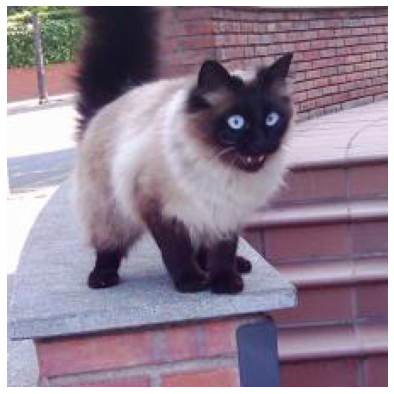

In [28]:
# 웹 사이트에서 임의로 이미지를 가져오기 (샘플)
image = skimage.io.imread("http://lorempixel.com/224/224/animals/")
assert image.shape == (224, 224, 3), "Must be 224x224 RGB Image"
tensor_summary(image)
display_images([image], cols=2)

In [29]:
# 이미지를 실수형으로 바꾸기
x = image.astype(np.float32) 
x = x[np.newaxis,...]

# 이미지 전처리하기
x = vgg16.preprocess_input(x)

In [30]:
# 모델 예측
predictions = model.predict(x)

# We'll get a 1000 values. Print the first 10.
print(predictions[0][:10])

[1.3425598e-09 1.0748400e-09 1.2055282e-09 1.1753937e-10 2.8247107e-09
 2.6175828e-09 2.2791444e-10 2.9431243e-08 7.8475679e-08 1.6006487e-09]


In [31]:
# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)

# Display the top 5 classes
vgg16.decode_predictions(predictions)

label index:  284
40960/35363 [==================================] - 0s 0us/step


[[('n02123597', 'Siamese_cat', 0.9985061),
  ('n02124075', 'Egyptian_cat', 0.0003931934),
  ('n02127052', 'lynx', 0.00024337543),
  ('n04493381', 'tub', 9.885677e-05),
  ('n03887697', 'paper_towel', 8.868996e-05)]]

# CNN Visualization

### 1) Heatmap
Heatmap 은 CNN 의 관심영역을 확인하기 위한 수단이다.

In [42]:
step = 56
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(16, 224, 224, 3)

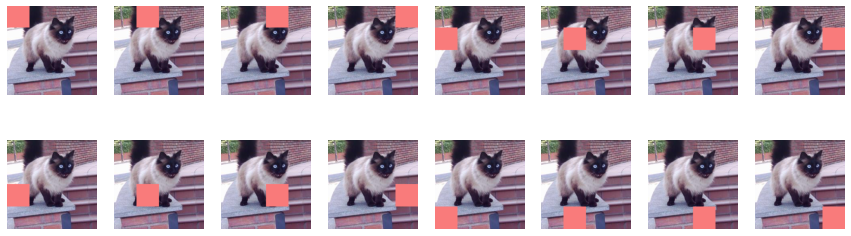

In [43]:
display_images(heatmap_x[:28], cols=8)

In [44]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (16, 1000)  min: 1.3786515332125937e-12  max: 0.999476969242096


In [45]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (16,)  min: 0.7621167898178101  max: 0.999476969242096


In [46]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
tensor_summary(heatmap)

shape: (4, 4)  min: 0.0  max: 1.0


shape: (4, 4)  min: 0.0  max: 1.0


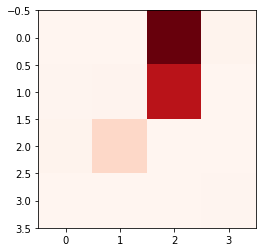

In [47]:
# heatmap 보여주기
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

shape: (224, 224, 3)  min: 4.537611675914377e-05  max: 201.46873474121094


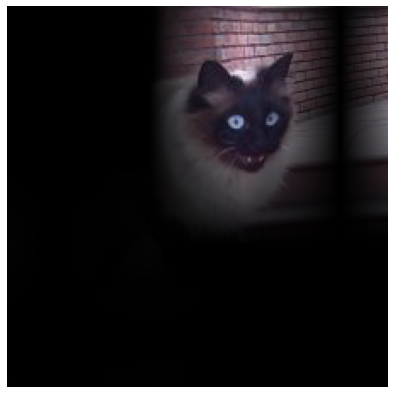

In [48]:
# heatmap 을 통해 이미지에 마스크 적용하기
def apply_mask(image, mask):
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


apply_mask(image, heatmap**2)

마스크를 이미지에 적용했을 때, 관심영역을 잘 나타내고 있음을 알 수 있다.

### 2) Visualize the Weights
잘 학습된 신경망은 노이즈 없이 훌륭하고 부드러운 필터를 표시한다. 가중치 시각화를 통해 모델이 잘 학습되었는지 알 수 있다.

#### 첫번째 레이어 가중치 시각화

In [142]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.6085159)

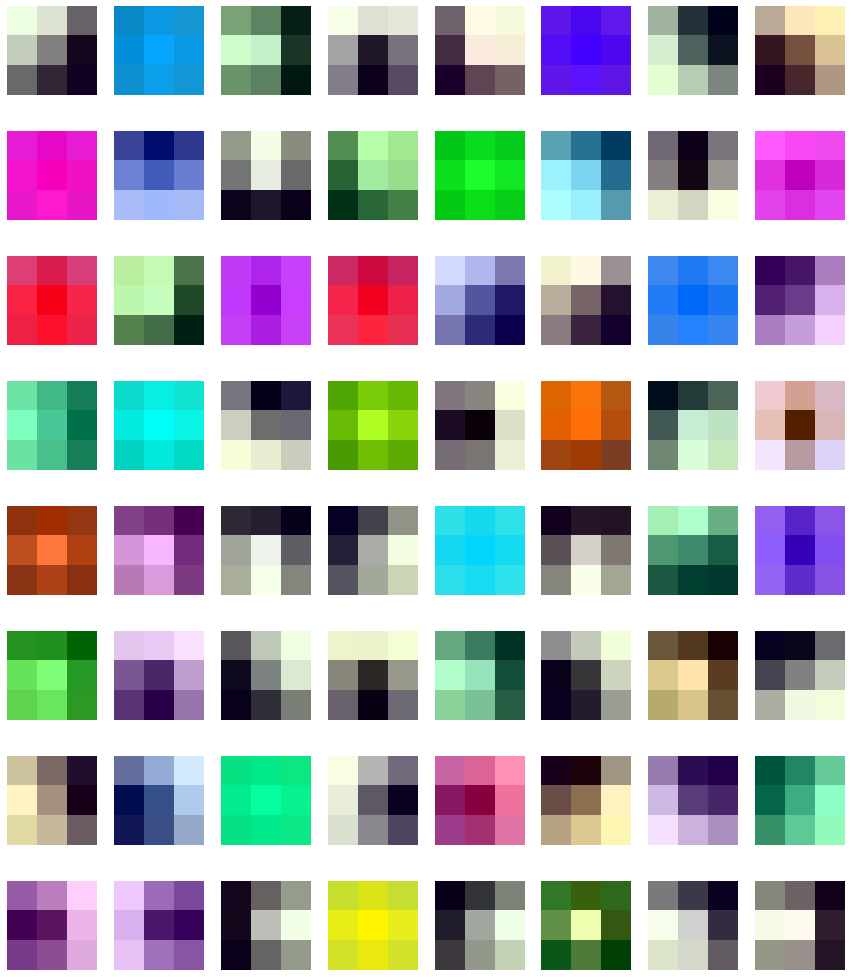

In [143]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=8, interpolation="none")

#### 세번째 레이어 가중치 시각화

In [144]:
weights = model.get_layer("block3_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 128, 256), -0.18306334, 0.5444108)

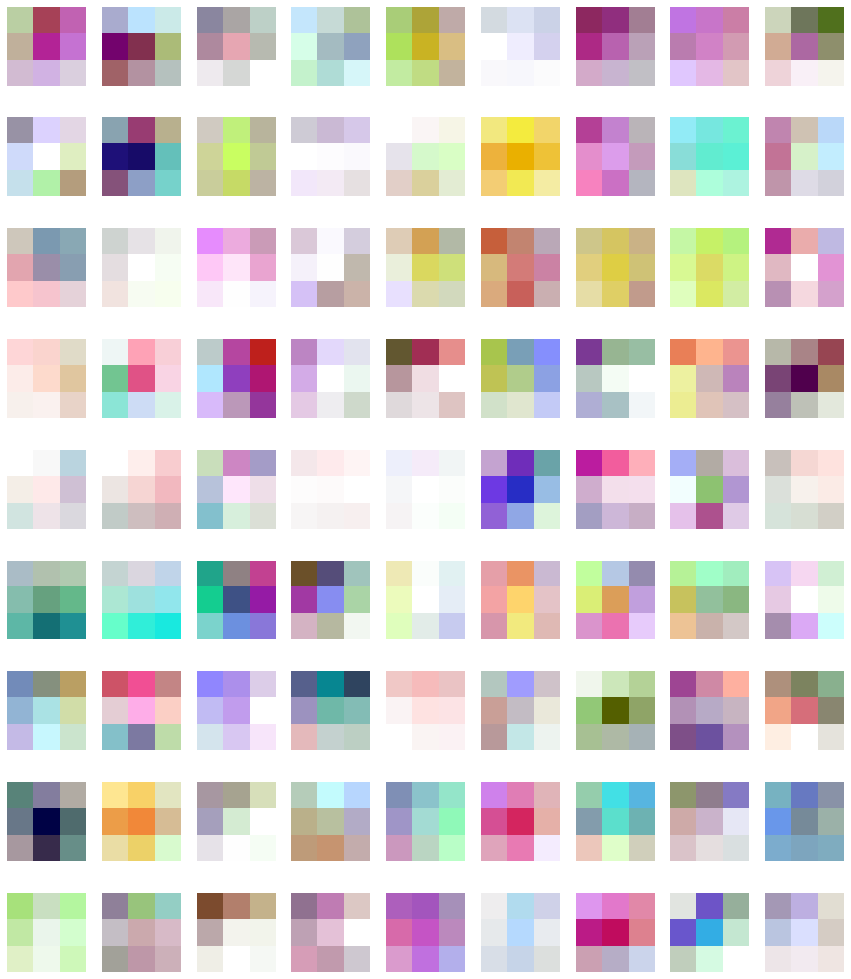

In [146]:
display_images([weights[:,:,:4,i] for i in range(81)], cols=9, interpolation="none")

#### 다섯번째 레이어 가중치 시각화

In [138]:
weights = model.get_layer("block5_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 512, 512), -0.113298565, 0.1904444)

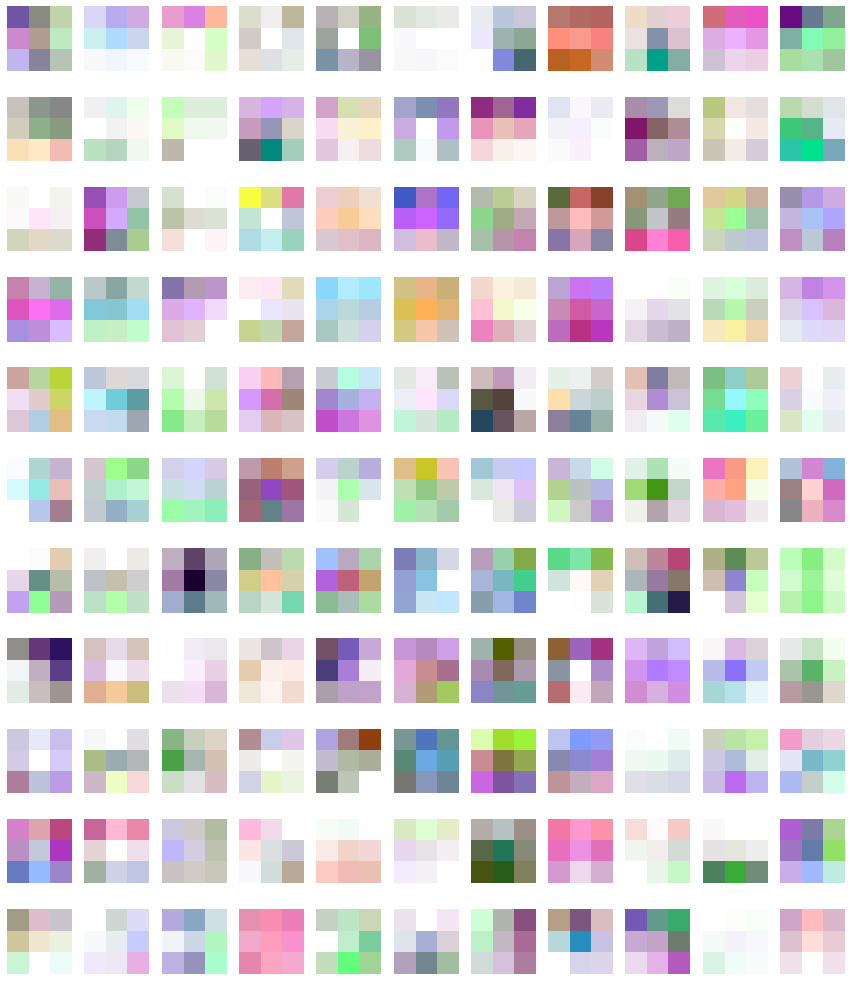

In [139]:
display_images([weights[:,:,:4,i] for i in range(121)], cols=11, interpolation="none")

### 3) Visualize Activations
가장 직접적인 시각화 기술은 activation layer 을 시각화시키는 것이다.

In [54]:
def read_layer(model, x, layer_name):
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

#### 첫번째 레이어 시각화

shape: (1, 224, 224, 64)  min: 0.0  max: 548.6527099609375


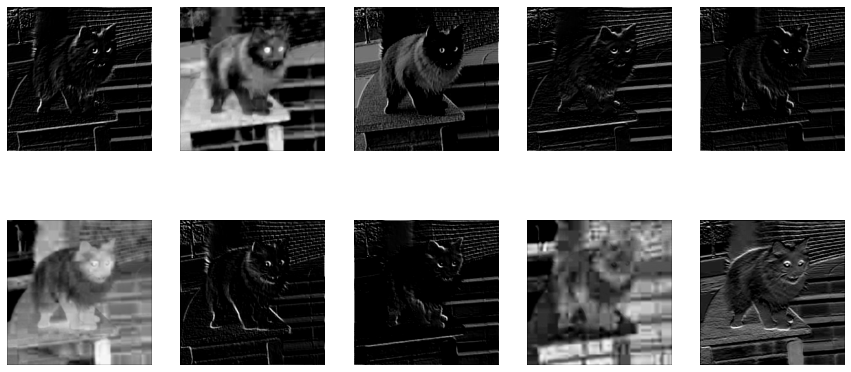

In [55]:
view_layer(model, x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 1888.0748291015625


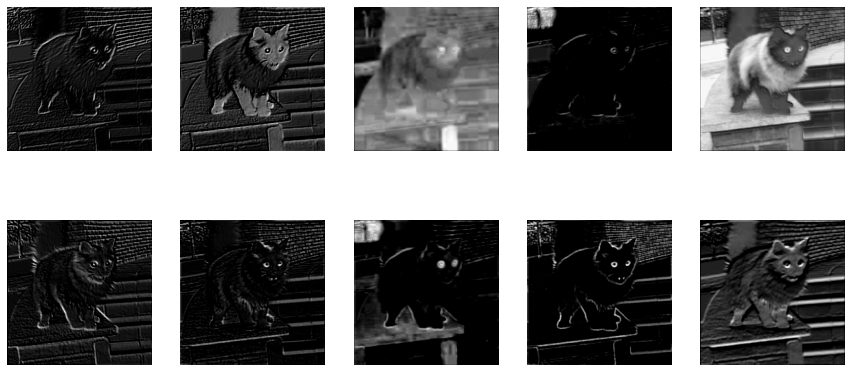

In [56]:
view_layer(model, x, "block1_conv2")

shape: (1, 112, 112, 64)  min: 0.0  max: 1888.0748291015625


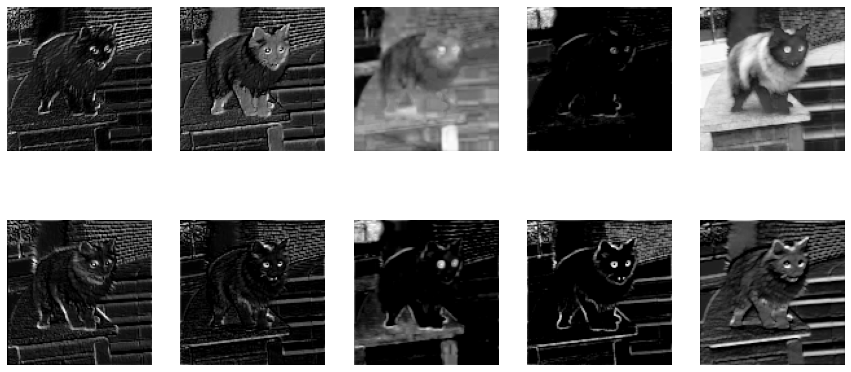

In [59]:
view_layer(model, x, "block1_pool")

#### 두번째 레이어 시각화

shape: (1, 112, 112, 128)  min: 0.0  max: 3575.29296875


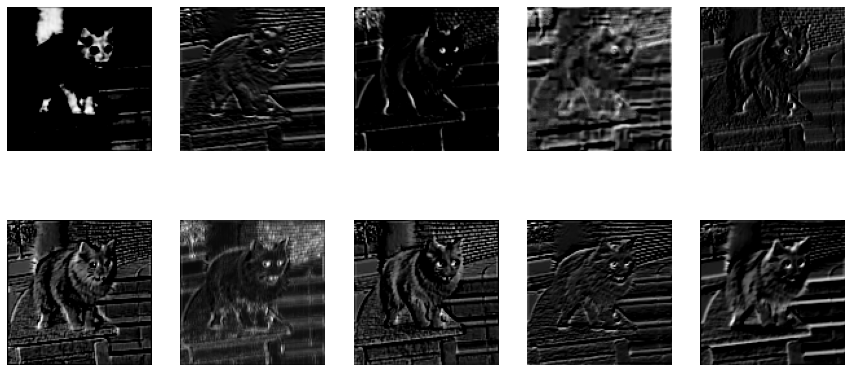

In [61]:
view_layer(model, x, "block2_conv1")

shape: (1, 112, 112, 128)  min: 0.0  max: 6237.33935546875


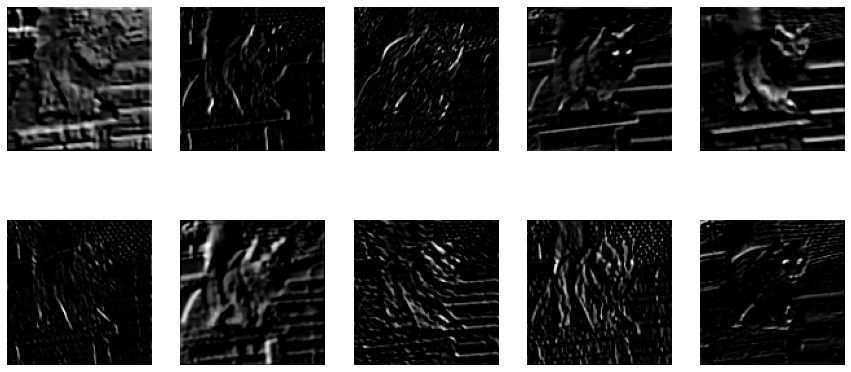

In [62]:
view_layer(model, x, "block2_conv2")

shape: (1, 56, 56, 128)  min: 0.0  max: 6237.33935546875


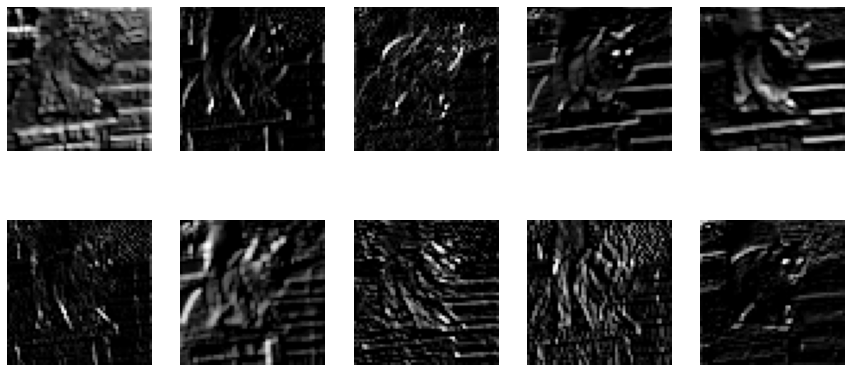

In [60]:
view_layer(model, x, "block2_pool")

#### 다섯번째 레이어 시각화

shape: (1, 14, 14, 512)  min: 0.0  max: 1834.9788818359375


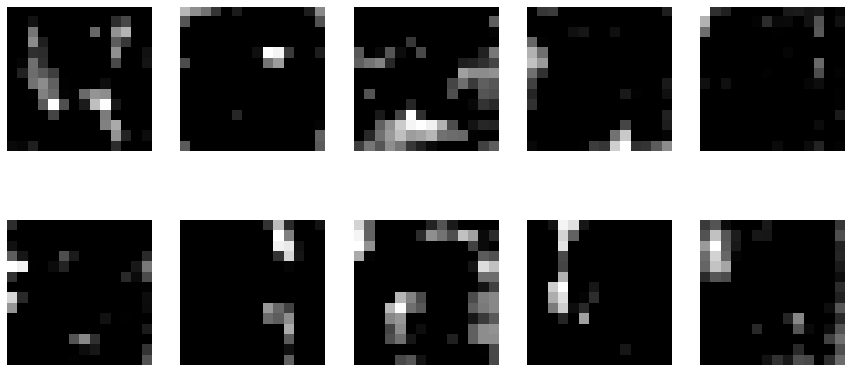

In [150]:
view_layer(model, x, "block5_conv1")

shape: (1, 14, 14, 512)  min: 0.0  max: 832.861328125


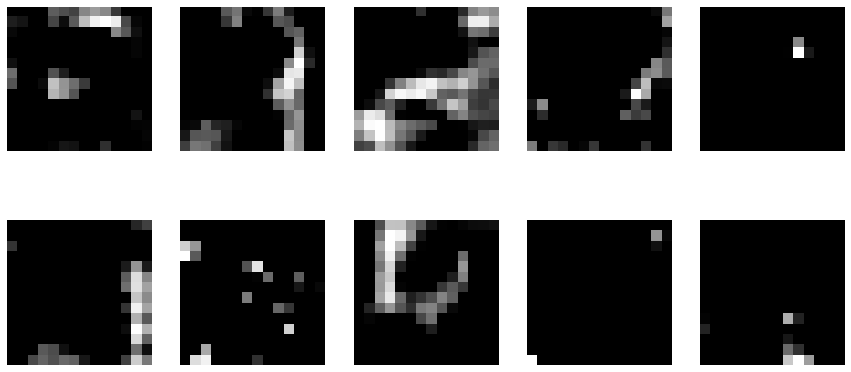

In [151]:
view_layer(model, x, "block5_conv2")

shape: (1, 7, 7, 512)  min: 0.0  max: 389.82904052734375


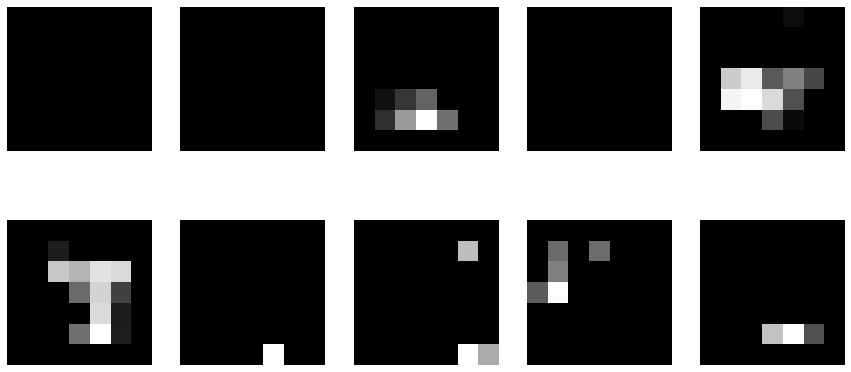

In [152]:
view_layer(model, x, "block5_pool")

얕은 레이어일수록 고양이의 귀와 같은 이미지의 큰 특징을 반영하는 feature map 을 만들고, 깊은 레이어일수록 이미지의 추상적인 곡선이나 형태만을 담은 feature map 을 만드는데 기여함을 알 수 있다.

shape: (1, 14, 14, 512)  min: 0.0  max: 832.861328125
shape: (224, 224, 3)  min: 0.0  max: 183.1283721923828


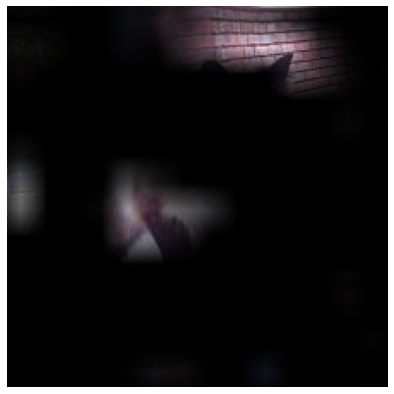

In [70]:
a = read_layer(model, x, "block5_conv2")
apply_mask(image, a[:,:, 0])

마지막 레이어의 conv2 에 마스크를 씌우면 고양이 귀 부분을 detect 하고 있음을 볼 수 있다.